# Bulldozer Price Prediction System Using Machine Learning

<img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3316/media/bulldozer.jpg>

Kaggle Link : https://www.kaggle.com/c/bluebook-for-bulldozers/overview

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

## Problem Definition

Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

## Data

Dataset Link : https://www.kaggle.com/c/bluebook-for-bulldozers/data

The data for this competition is split into three parts:
- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- Test.csv is the test set. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:
- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

## Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

## Table of contents

1. Environment setup 
2. Gathering the data 
3. Data Preprocessing and EDA 
   - Feature extraction 
   - Converting Strings to Categories 
   - Fill missing values 
4. Model experimentation
   - Hyperparameter tuning tsing RandomizedSearchCV 
   - Training the model with best parameters 
5. Predictions on test dataset 
6. Feature importance 

## 1. Environment setup

In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Scikit-Learn Packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## 2. Gathering the data

In [2]:
# Import training and validation dataset
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

# Import the test dataset
df_test = pd.read_csv("data/Test.csv", low_memory=False)

## 3. Data Preprocessing and EDA

In [3]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
# Import training and validation dataset after parsing the dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [6]:
df["saledate"].dtype

dtype('<M8[ns]')

In [7]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [8]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

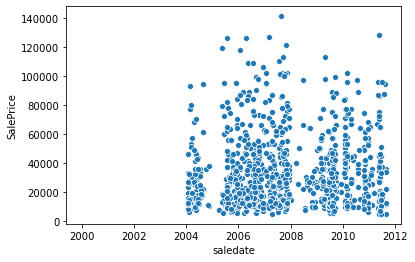

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(df["saledate"][:1000], df["SalePrice"][:1000])

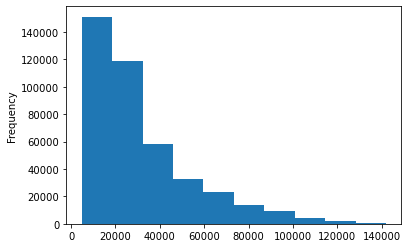

In [10]:
df.SalePrice.plot.hist()

In [11]:
df_test.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'saledate',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 1834 non-null   object 
 8   saledate                  12457 non-null  object 
 9   fiModelDesc               12457 non-null  object 
 10  fiBaseModel               12457 non-null  object 
 11  fiSecondaryDesc           8482 non-null   object 
 12  fiModelSeries             2006 non-null   object 
 13  fiModelDescriptor         3024 non-null   object 
 14  Produc

In [13]:
# Import test dataset with parsed dates
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])

In [14]:
df_test["saledate"].dtype

dtype('<M8[ns]')

In [15]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688,28555,6038,8940,2286
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [16]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [17]:
# Sort the DataFrame accoring to saledate
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [18]:
# Make a copy of the dataframe
df_tmp = df.copy()

In [19]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### 3.1 Feature Extraction

In [20]:
# Add datetime parameters for saledate column
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day

In [21]:
df_tmp.head(20).T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,113394,116419,32138,127610,76171,127000,128130,127626,55455,55454
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,1449555,1453775,1264985,1475641,1364654,1474844,1476264,1475662,1305337,1305336
SalePrice,9500,14000,50000,16000,22000,23500,31000,11750,63000,13000,10500,20000,20000,23500,14000,11250,29000,22000,17000,17000
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,1102310,1514650,1204499,1194367,1270628,1279993,1245504,1242833,1517075,1236263
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,3356,7008,6788,7277,7289,7257,7277,7277,3356,3356
datasource,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132,132
auctioneerID,18,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,1966,1974,1984,1973,1968,1979,1978,1973,1972,1972
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [22]:
# Dropping saledate since we have already extracted the features from it
df_tmp.drop("saledate", axis=1, inplace=True)

### 3.2 Converting Strings to Category

In [23]:
# Converting Strings to Category
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [24]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 55 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [25]:
df_tmp["state"].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [26]:
# Check percentage of missing data
(df_tmp.isnull().sum()/len(df_tmp))*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

### 3.3 Filling missing values

In [27]:
# Filling missing numeric values with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

# Turning categories into numbers and add one
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers and add + 1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [28]:
# Check percentage of missing data
(df_tmp.isnull().sum()/len(df_tmp))*100

SalesID                     0.0
SalePrice                   0.0
MachineID                   0.0
ModelID                     0.0
datasource                  0.0
auctioneerID                0.0
YearMade                    0.0
MachineHoursCurrentMeter    0.0
UsageBand                   0.0
fiModelDesc                 0.0
fiBaseModel                 0.0
fiSecondaryDesc             0.0
fiModelSeries               0.0
fiModelDescriptor           0.0
ProductSize                 0.0
fiProductClassDesc          0.0
state                       0.0
ProductGroup                0.0
ProductGroupDesc            0.0
Drive_System                0.0
Enclosure                   0.0
Forks                       0.0
Pad_Type                    0.0
Ride_Control                0.0
Stick                       0.0
Transmission                0.0
Turbocharged                0.0
Blade_Extension             0.0
Blade_Width                 0.0
Enclosure_Type              0.0
Engine_Horsepower           0.0
Hydrauli

### 3.4 Preprocessing the test dataset

In [29]:
# Function to preprocess the test dataset
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with median 
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
            
    # Fill categorical missing data and turned categories in numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Turn categories into numbers and add + 1
            df[label] = pd.Categorical(content).codes + 1
        
    return df

In [30]:
# Preprocess the Test Data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,0,0,0,0,0,0,0,2012,5,3
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,0,0,0,0,0,3,2,2012,5,10
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,1,1,0,0,0,0,0,2012,5,10
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,2,2,0,0,0,0,0,2012,5,10
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,0,0,1,4,5,0,0,2012,5,10


## 4. Model experimentation

In [31]:
# Scoring function for our model
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [32]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 54), (401125,), (11573, 54), (11573,))

In [33]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [34]:
%%time
# Cutting down the max number of samples to improve training time
model.fit(X_train, y_train)

Wall time: 2.87 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [35]:
show_scores(model)

{'Training MAE': 5530.69139677158,
 'Valid MAE': 7088.086306921282,
 'Training RMSLE': 0.25641237450190857,
 'Valid RMSLE': 0.28910460721812337,
 'Training R^2': 0.8620098420071409,
 'Valid R^2': 0.8346813777595806}

### 4.1 Hyperparameter Tuning using RandomizedSearchCV

In [36]:
%%time

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=10,
                              verbose=True,
                              n_jobs=-1)

# Fit the model
rs_model.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  9.0min finished


Wall time: 9min 5s


RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [37]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [38]:
# Evaluate the RandomizedSearchModel
show_scores(rs_model)

{'Training MAE': 5655.326040261923,
 'Valid MAE': 7225.696440135016,
 'Training RMSLE': 0.26069190865404174,
 'Valid RMSLE': 0.2947203927619474,
 'Training R^2': 0.8552180874357341,
 'Valid R^2': 0.828357723313957}

### 4.2 Training the model with the best hyperparameters

Training the model with hyperparameters after 100 iterations

In [39]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

Wall time: 20.1 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [40]:
show_scores(ideal_model)

{'Training MAE': 3012.339056048825,
 'Valid MAE': 5926.4645586795905,
 'Training RMSLE': 0.14675777955696878,
 'Valid RMSLE': 0.244399297589895,
 'Training R^2': 0.9574270045327707,
 'Valid R^2': 0.8815545551038035}

## 5. Predictions on test dataset

In [41]:
test_preds = ideal_model.predict(df_test)

In [42]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,17267.593156
1,1227844,17472.438056
2,1227847,51345.543689
3,1227848,71683.069195
4,1227863,58380.781438
...,...,...
12452,6643171,38096.128259
12453,6643173,11726.751278
12454,6643184,12667.570078
12455,6643186,15862.694015


## 6. Feature importance

In [43]:
ideal_model.feature_importances_

array([3.36848150e-02, 2.00790031e-02, 5.12543654e-02, 2.26755092e-03,
       3.80598358e-03, 1.92690213e-01, 3.57121130e-03, 1.24984703e-03,
       4.55264673e-02, 4.13331084e-02, 6.81067541e-02, 5.34370760e-03,
       2.87232241e-02, 1.51049673e-01, 5.10467580e-02, 6.81605667e-03,
       2.55050075e-03, 5.83295271e-03, 3.32948504e-03, 8.17307426e-02,
       1.32931975e-03, 3.07920626e-04, 1.39941193e-03, 2.08266130e-04,
       1.68817462e-03, 8.78074608e-05, 2.14493424e-04, 7.47835295e-03,
       3.14078725e-03, 6.59844543e-04, 8.58704534e-03, 3.38774429e-03,
       5.27018080e-03, 7.64880907e-04, 5.46022355e-03, 1.49599765e-02,
       1.31294180e-03, 2.63278503e-02, 8.69576761e-03, 4.05313257e-03,
       2.11827045e-03, 1.04326416e-03, 9.97619619e-04, 8.03737818e-04,
       7.60511318e-04, 5.18530562e-04, 7.79488318e-04, 4.79611635e-03,
       1.27005099e-03, 3.97280537e-04, 1.54045674e-03, 7.50197776e-02,
       7.99646374e-03, 6.63188967e-03])

In [44]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

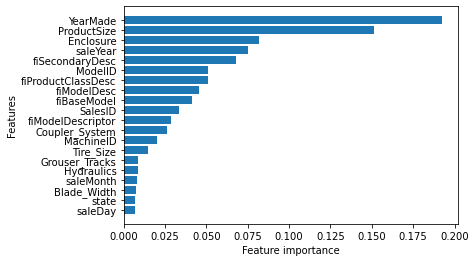

In [45]:
plot_features(X_train.columns, ideal_model.feature_importances_)